# Examples GEM EO datasets of derived data

This is a notebook showcasing workflow examples for downloading EO derived data from data collections available through Sentinel Hub.

### Data download examples in this notebook:

1.  Sentinel-2 L2A 120m Mosaic

2.  Corine Land Cover

3.  Corine Land Cover Accounting Layers

4.  ESA WorldCover

5.  Global Land Cover

6.  Global Surface Water

7.  Global Human Settlements Layer 

8.  Theia Land Cover Map

9.  Sentinel-2 Scene Classification Layer (from Sen2cor) 



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
from aenum import MultiValueEnum
from eolearn.core import FeatureType
from eolearn.io import SentinelHubEvalscriptTask, SentinelHubInputTask
from eolearn.visualization import PlotConfig
from matplotlib.colors import BoundaryNorm, ListedColormap
from sentinelhub import BBox, Band, CRS, DataCollection, Unit

from derived_data_codelists import CLC, CLC_ACC, GLC, TLCM, EWC, SCL, rgb_int, construct_cmap

### General parameters

In [2]:
# region of interest
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
roi1_bbox = BBox(bbox=[4.972687, 43.495772, 5.637360, 43.855326], crs=CRS.WGS84)
large_bbox = BBox(bbox=[-10.524902, 33.651208, 11.711426, 44.213710], crs=CRS.WGS84)
coast_bbox = BBox(bbox=[-0.05, 40.23, 0.61, 40.63], crs=CRS.WGS84)

# configure the plotting
plot_config = PlotConfig(subplot_width=10, subplot_height=10, rgb_factor=2.5, show_title=False)

###  1.  Sentinel-2 L2A 120m Mosaic ( [Sentinel-2 L2A 120m Mosaic](https://collections.sentinel-hub.com/sentinel-s2-l2a-mosaic-120/) )

In [3]:
band_names = ["B02", "B03", "B04"]
S2_mosaic_data_collection = DataCollection.define_byoc(
    "484d8dbb-9e3e-41f2-b96b-35189d3ae37f",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.uint16,)) for name in band_names],
)

In [4]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03","B04"],
    output: [
        {
          id: "bands",
          bands: 3,
          sampleType: "UINT16"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.B02, sample.B03, sample.B04];
}
"""

In [5]:
mosaic_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript,
    data_collection=S2_mosaic_data_collection,
    resolution=120,
    max_threads=3,
)

In [6]:
eopatch_mosaic = mosaic_download_task.execute(bbox=coast_bbox, time_interval=["2020-07-01", "2020-07-15"])

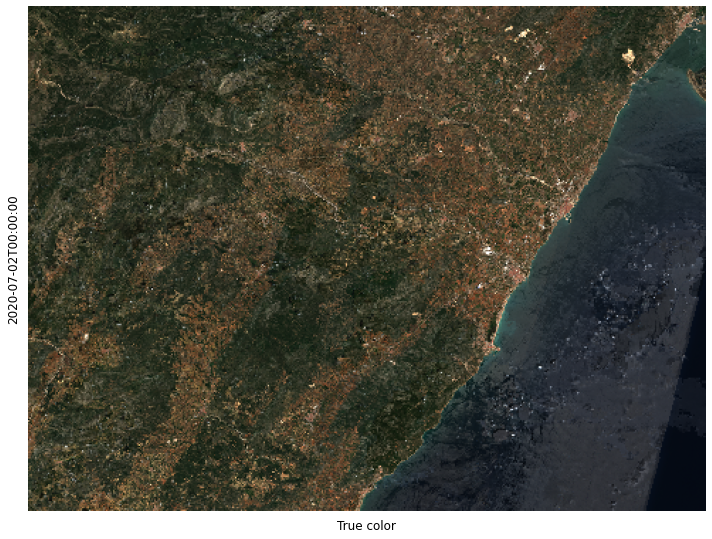

In [7]:
eopatch_mosaic.plot(
    (FeatureType.DATA, "bands"),
    rgb=[2, 1, 0],
    channel_names=["True color"],
    times=[0],
    config=PlotConfig(subplot_width=10, show_title=False, rgb_factor=2.5 / 10000),
);

### 2. Corine Land Cover ( [CLC](https://collections.sentinel-hub.com/corine-land-cover/) ) 

In [8]:
clc_data_collection = DataCollection.define_byoc(
    "cbdba844-f86d-41dc-95ad-b3f7f12535e9",
    service_url="https://creodias.sentinel-hub.com",
    bands=[Band(name="CLC", units=(Unit.DN,), output_types=(np.uint8,))],
)

In [9]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLC"],
    output: [
        {
          id: "CLC_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.CLC];
}
"""

In [10]:
clc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "CLC_data"),
    evalscript=evalscript,
    data_collection=clc_data_collection,
    resolution=30,
    max_threads=3,
)

In [11]:
eopatch_clc = clc_download_task.execute(bbox=coast_bbox, time_interval=["2017-01-01", "2019-01-01"])

In [12]:
clc_cmap, clc_norm, clc_ticks, clc_labels = construct_cmap(CLC, eopatch_clc.data["CLC_data"], name="clc_cmap")

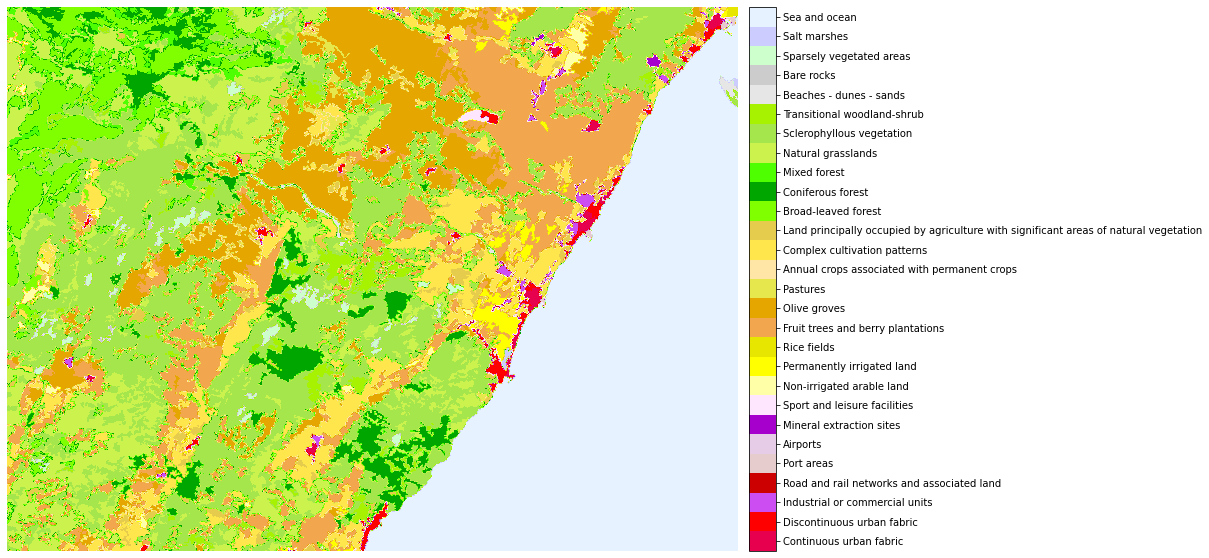

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = plt.imshow(eopatch_clc.data["CLC_data"][0].squeeze(), cmap=clc_cmap, norm=clc_norm)
plt.axis(False)

cb = fig.colorbar(im, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(clc_ticks)
cb.set_ticklabels(clc_labels);

### 3. Corine Land Cover Accounting Layers ( [CLC_ACC](https://collections.sentinel-hub.com/corine-land-cover-accounting-layers/) ) 

In [14]:
clcacc_data_collection = DataCollection.define_byoc(
    "4c5441a6-6040-4dc4-a392-c1317bbd1031",
    service_url="https://creodias.sentinel-hub.com",
    bands=[Band(name="CLC_ACC", units=(Unit.DN,), output_types=(np.uint8,))],
)

In [15]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLC_ACC"],
    output: [
        {
          id: "CLC_ACC_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.CLC_ACC];
}
"""

In [16]:
clcacc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "CLC_ACC_data"),
    evalscript=evalscript,
    data_collection=clcacc_data_collection,
    resolution=30,
    max_threads=3,
)

In [17]:
eopatch_clcacc = clcacc_download_task.execute(bbox=roi1_bbox, time_interval=["2017-01-01", "2019-01-01"])

In [18]:
clc_cmap, clc_norm, clc_ticks, clc_labels = construct_cmap(
    CLC_ACC, eopatch_clcacc.data["CLC_ACC_data"], name="clc_acc_cmap"
)

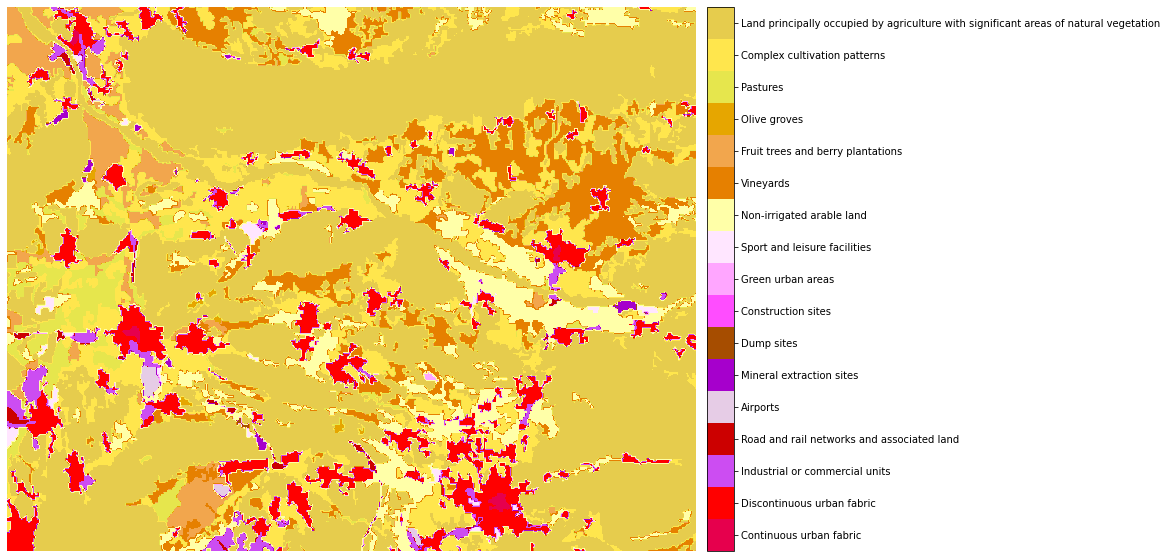

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = plt.imshow(eopatch_clcacc.data["CLC_ACC_data"][0].squeeze(), cmap=clc_cmap, norm=clc_norm)
plt.axis(False)

cb = fig.colorbar(im, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(clc_ticks)
cb.set_ticklabels(clc_labels);

### 4. ESA WorldCover ( [EWC](https://collections.sentinel-hub.com/worldcover/ ) )

In [20]:
ewc_data_collection = DataCollection.define_byoc(
    "0b940c63-45dd-4e6b-8019-c3660b81b884",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name="Map", units=(Unit.DN,), output_types=(np.uint8,))],
)

In [21]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["Map"],
    output: [
        {
          id: "EWC_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.Map];
}
"""

In [22]:
ewc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "EWC_data"),
    evalscript=evalscript,
    data_collection=ewc_data_collection,
    resolution=30,
    max_threads=3,
)

In [23]:
eopatch_ewc = ewc_download_task.execute(bbox=roi1_bbox, time_interval=["2020-01-01", "2020-01-01"])

In [24]:
ewc_cmap, ewc_norm, ewc_ticks, ewc_labels = construct_cmap(EWC, eopatch_ewc.data["EWC_data"], name="ewc_cmap")

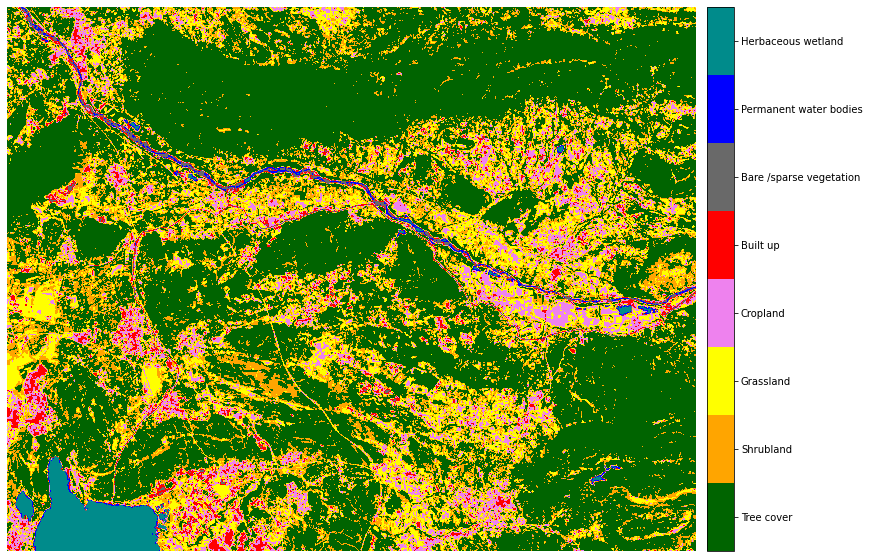

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im1 = plt.imshow(eopatch_ewc.data["EWC_data"].squeeze(), cmap=ewc_cmap, norm=ewc_norm)
plt.imshow(eopatch_ewc.data["EWC_data"].squeeze(), cmap=ewc_cmap)
plt.axis(False)

cb = fig.colorbar(im1, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(ewc_ticks)
cb.set_ticklabels(ewc_labels);


### 5.  Global Land Cover ( [GLC](https://collections.sentinel-hub.com/global-land-cover/) )

In [26]:
glc_data_collection = DataCollection.define_byoc(
    "f0a97620-0e88-4c1f-a1ac-bb388fabdf2c",
    service_url="https://creodias.sentinel-hub.com",
    bands=[
        Band(name="Discrete_Classification_map", units=(Unit.DN,), output_types=(np.uint8,)),
        Band(name="Grass_CoverFraction_layer", units=(Unit.DN,), output_types=(np.uint8,)),
    ],
)

In [27]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["Discrete_Classification_map", "Grass_CoverFraction_layer"],
    output: [
        {
          id: "GLC_data",
          bands: 2,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.Discrete_Classification_map, sample.Grass_CoverFraction_layer];
}
"""

In [28]:
glc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "GLC_data"),
    evalscript=evalscript,
    data_collection=glc_data_collection,
    resolution=30,
    max_threads=3,
)

In [29]:
eopatch_glc = glc_download_task.execute(bbox=roi1_bbox, time_interval=["2019-01-01", "2020-12-01"])

In [30]:
glc_cmap, glc_norm, glc_ticks, glc_labels = construct_cmap(GLC, eopatch_glc.data["GLC_data"], name="glc_cmap")

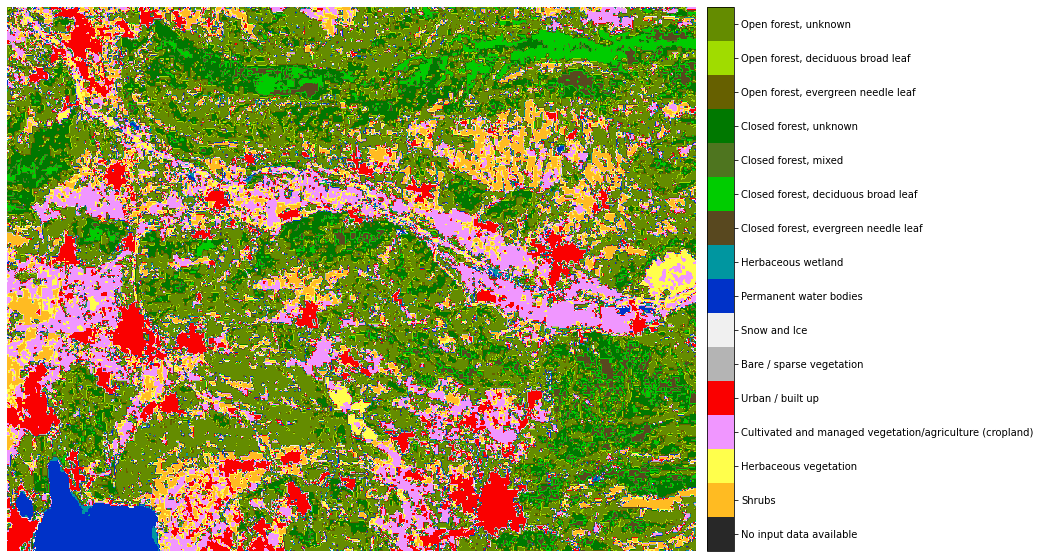

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = plt.imshow(eopatch_glc.data["GLC_data"][0][..., [0]].squeeze(), cmap=glc_cmap, norm=glc_norm)
plt.axis(False)

cb = fig.colorbar(im, orientation="vertical", pad=0.01, aspect=20)

cb.set_ticks(glc_ticks)
cb.set_ticklabels(glc_labels);

### 6.  Global Surface Water ( [GSW](https://collections.sentinel-hub.com/global-surface-water/readme.html) )

In [32]:
gsw_data_collection = DataCollection.define_byoc(
    "9a525f12-33b6-424e-a0f2-d567eec0f277",
    service_url="https://creodias.sentinel-hub.com",
    bands=[Band(name="occurrence", units=(Unit.DN,), output_types=(np.uint8))],
)

In [33]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["occurrence"],
    output: [
        {
          id: "GSW_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.occurrence];
}
"""

In [34]:
gsw_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "GSW_data"),
    evalscript=evalscript,
    data_collection=gsw_data_collection,
    resolution=30,
    max_threads=3,
)

In [35]:
eopatch_gsw = gsw_download_task.execute(bbox=roi1_bbox, time_interval=["2020-01-01", "2020-12-01"])

In [36]:
class GSW(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NOT_WATER = "Not water", 0, "#ffffff"
    PERCENT_1 = "1% occurrence", 1, "#ffcccc"
    PERCENT_100 = "100% occurrence", 100, "#0000ff"
    NO_DATA = "No data", 255, "#cccccc"

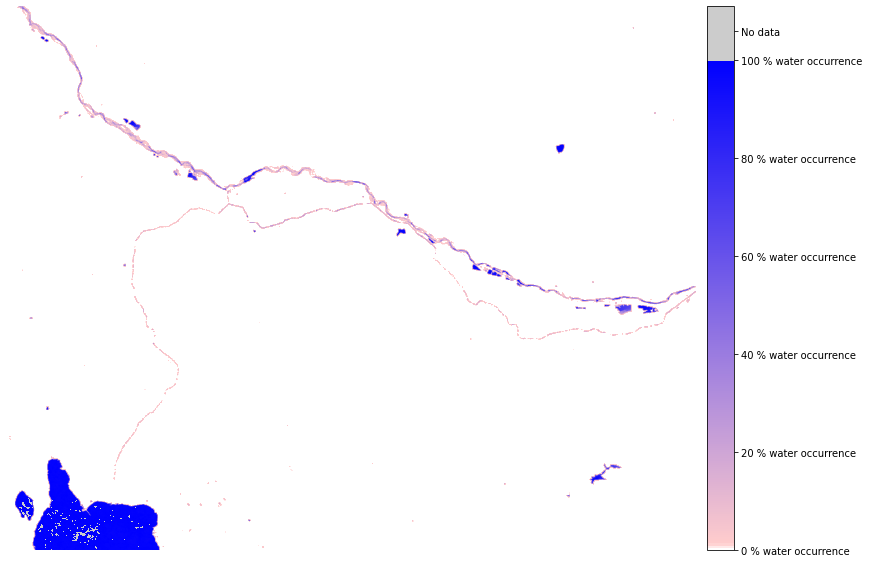

In [37]:
GSW_rows = []
[GSW_rows.append([entry.values[0], entry.values[1], entry.values[2]]) for entry in GSW]

GSW_clrs = []
[GSW_clrs.append(rgb_int(entry)) for entry in GSW_rows]


GSW_vals = eopatch_gsw.data["GSW_data"]
norm = plt.Normalize(0, 111)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", GSW_clrs[0:-1])
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [(0, GSW_clrs[0]), (0.009, GSW_clrs[1]), (0.9, GSW_clrs[2]), (0.901, GSW_clrs[3]), (1, GSW_clrs[3])]
)

gws_norm = BoundaryNorm([1, 111], 2)

plt.figure(figsize=(20, 10))
plt.imshow(eopatch_gsw.data["GSW_data"].squeeze(), cmap=cmap1, norm=norm)
plt.axis(False)

ticks = [i for i in range(0, 101, 20)]
ticks.append(106)
tick_labels = [f"{i} % water occurrence" for i in range(0, 101, 20)]
tick_labels.append("No data")

cb = plt.colorbar(pad=0.01)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels)

### 7.  Global Human Settlements Layer  ( [GHSL](https://collections.sentinel-hub.com/global-human-settlement-layer-ghs-built-s2/) )

In [38]:
ghsl_data_collection = DataCollection.define_byoc(
    "3dbeea2c-3207-4c65-8a73-c29ce2675f89",
    service_url="https://creodias.sentinel-hub.com",
    bands=[
        Band(
            name="PROB",
            units=(Unit.DN,),
            output_types=(np.uint8,),
        )
    ],
)

In [39]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["PROB"],
    output: [
        {
          id: "GHSL_PROB",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.PROB];
}
"""

In [40]:
ghsl_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "GHSL_PROB"),
    evalscript=evalscript,
    data_collection=ghsl_data_collection,
    resolution=30,
    max_threads=3,
)

In [41]:
eopatch_ghsl = ghsl_download_task.execute(bbox=roi1_bbox, time_interval=["2017-01-01", "2019-01-01"])

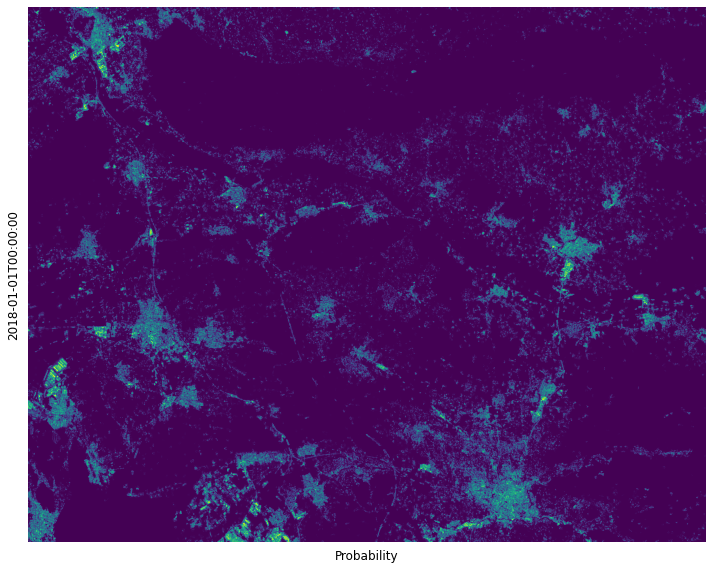

In [54]:
eopatch_ghsl.plot((FeatureType.DATA, "GHSL_PROB"), channel_names=["Probability"], config=plot_config);

### 8.  Theia (CNES) Land Cover Map  ( [TLCM](https://collections.sentinel-hub.com/cnes-land-cover-map/) )

In [43]:
tlcm_data_collection = DataCollection.define_byoc(
    "9baa2732-6597-49d2-ae3b-68ba0a5386b2",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name="OCS", units=(Unit.DN,), output_types=(np.uint8,))],
)

In [44]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["OCS"],
    output: [
        {
          id: "TLCM_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.OCS];
}
"""

In [45]:
tlcm_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "TLCM_data"),
    evalscript=evalscript,
    data_collection=tlcm_data_collection,
    resolution=30,
    max_threads=3,
)

In [46]:
eopatch_tlcm = tlcm_download_task.execute(bbox=roi1_bbox, time_interval=["2020-01-01", "2020-12-01"])

In [47]:
tlcm_cmap, tlcm_norm, tlcm_ticks, tlcm_labels = construct_cmap(TLCM, eopatch_tlcm.data["TLCM_data"], name="tlcm_cmap")

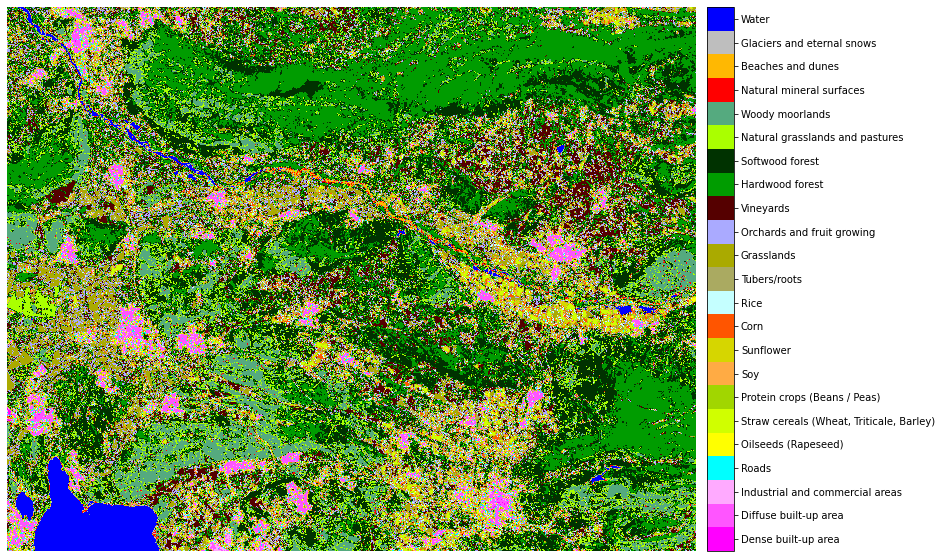

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im1 = plt.imshow(eopatch_tlcm.data["TLCM_data"].squeeze(), cmap=tlcm_cmap, norm=tlcm_norm)
im2 = plt.imshow(eopatch_tlcm.data["TLCM_data"][0].squeeze(), cmap=tlcm_cmap)
plt.axis(False)

cb = fig.colorbar(im1, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(tlcm_ticks)
cb.set_ticklabels(tlcm_labels);

### 9. Sentinel-2 Scene Classification Layer (from [Sen2Cor](https://www.sentinel-hub.com/develop/api/ogc/custom-parameters/atmospheric-correction/))

In [49]:
scl_data = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    additional_data=[(FeatureType.MASK, "SCL")],
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(hours=2),
    max_threads=3,
)

In [50]:
scl_eopatch = scl_data.execute(bbox=roi_bbox, time_interval=["2022-07-03", "2022-07-05"])

In [51]:
scl_bounds = [-0.5 + i for i in range(len(SCL) + 1)]
scl_cmap = ListedColormap([x.rgb for x in SCL], name="scl_cmap")
scl_norm = BoundaryNorm(scl_bounds, scl_cmap.N)

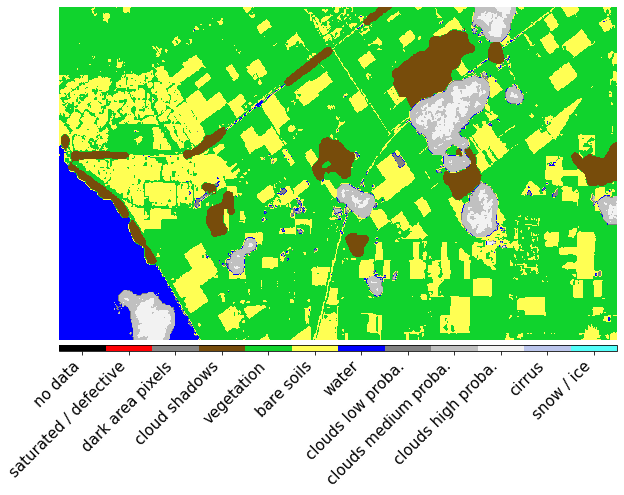

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = plt.imshow(scl_eopatch.mask["SCL"][0].squeeze(), cmap=scl_cmap, norm=scl_norm)
plt.axis(False)

cb = fig.colorbar(im, orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.values[1] for entry in SCL])
cb.ax.set_xticklabels([entry.values[0] for entry in SCL], rotation=45, fontsize=15, ha="right");